In [ ]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install


/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10
['Sonora' 'Baja California' 'Chihuahua' 'Coahuila' 'Tamaulipas'
 'Nuevo León' 'Quintana Roo' 'Campeche' 'Tabasco' 'Chiapas' 'Colima'
 'Nayarit' 'Baja California Sur' 'Sinaloa' 'Yucatán' 'Veracruz' 'Jalisco'
 'Michoacán' 'Guerrero' 'Oaxaca' None 'México' 'Puebla' 'Morelos'
 'Querétaro' 'Hidalgo' 'Guanajuato' 'San Luis Potosí' 'Zacatecas'
 'Aguascalientes' 'Durango' 'Tlaxcala' 'Distrito Federal']

-------Distrito Federal-------

670000.0
8900000.0
len df_prediction 5063
len df 45563
len df_prediction 5063
len df 45563
len df_prediction 5063
len df 45563
len df_prediction 5063
len df 45563
len df_prediction 5063
len df 45563
len df_prediction 5063
len df 45563
len df_prediction 5063
len df 45563
len df_prediction 5063
len df 45563
len df_prediction 5063
len df 45563
len df_prediction 5063
len df 45563

-------Jalisco-------

450000.0
6490000.0
len df_prediction 1799
len df 16189
len df_prediction 1799
len df 16189
le

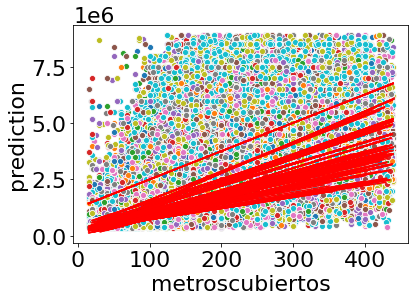

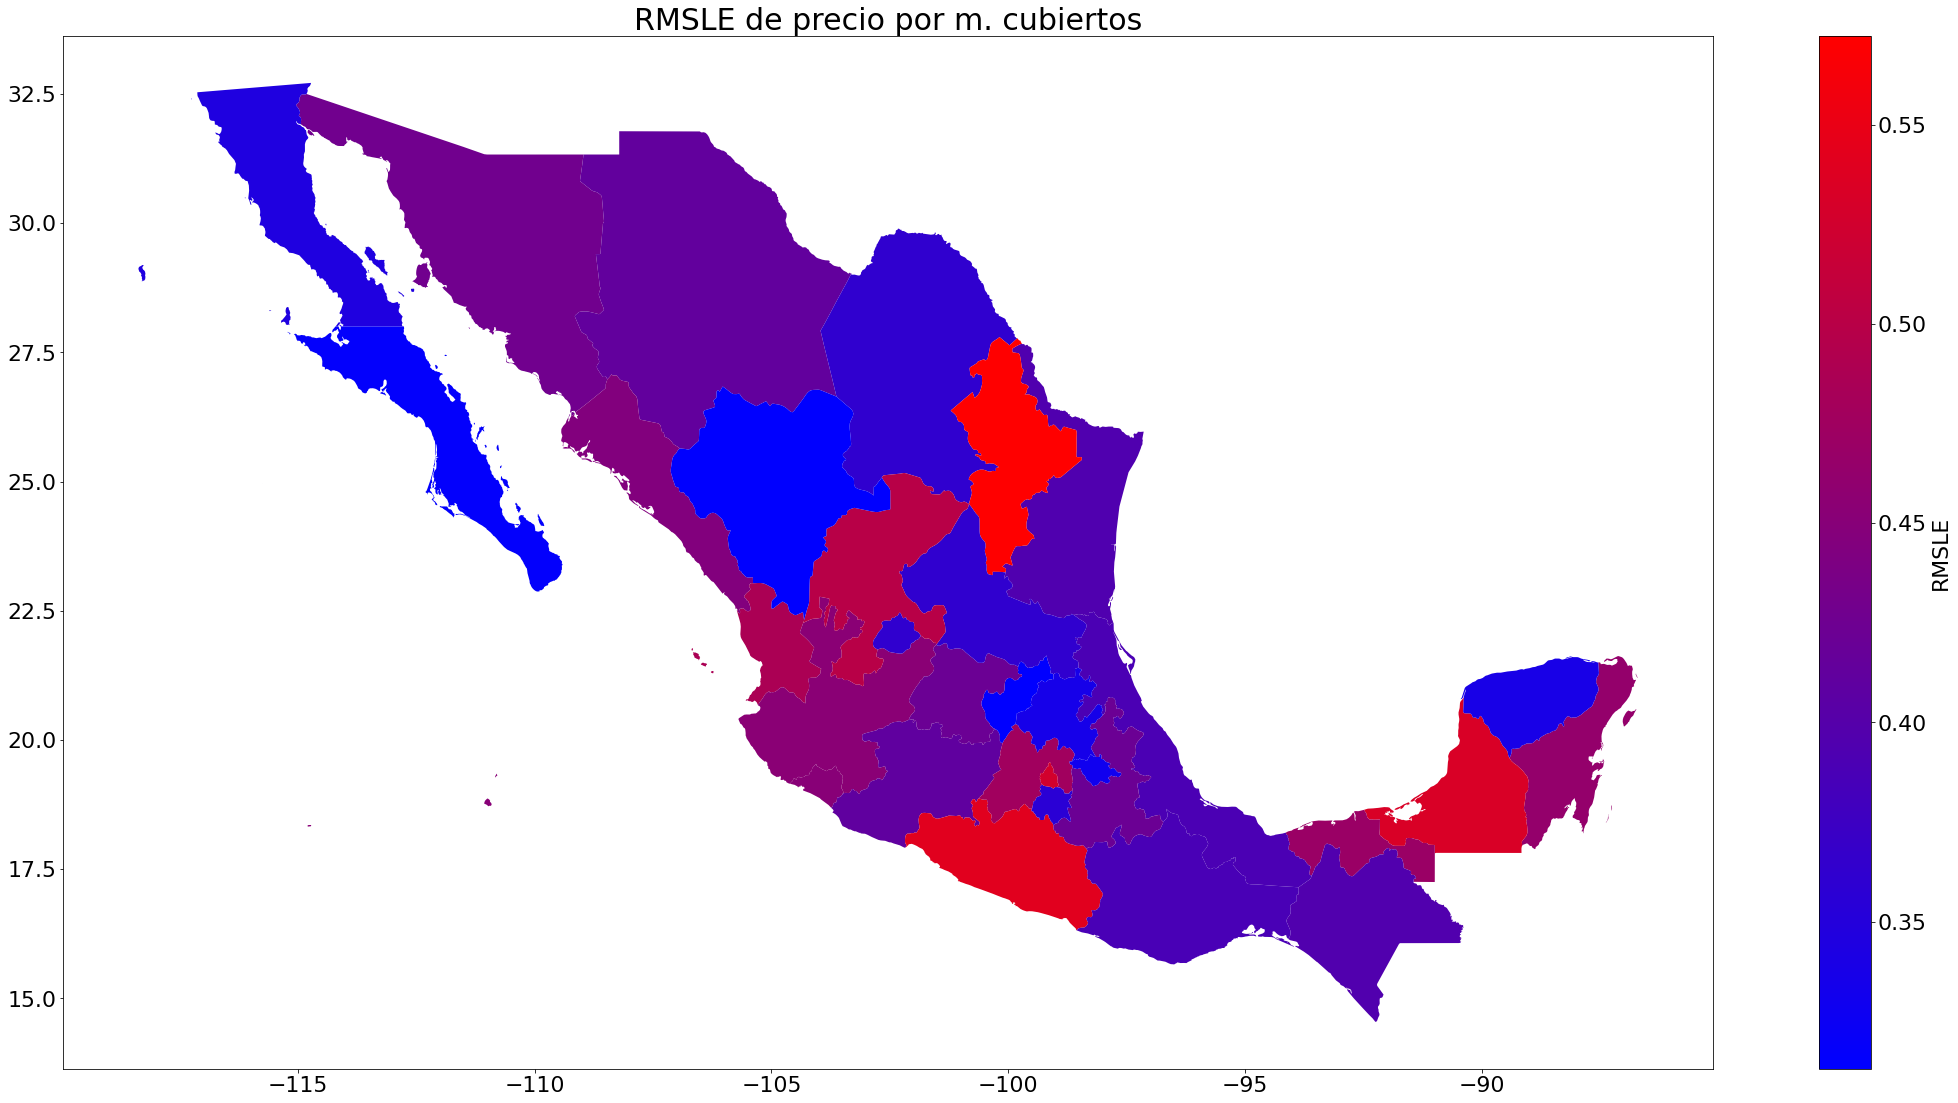

In [10]:
import geopandas as gpd
import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *
from matplotlib.colors import LinearSegmentedColormap

!pwd
!python --version
import metnum

def calculate_metrics(variable_to_predict, df_old):
    df = df_old.copy(deep=True)
    df = df[df['prediction'].notna()]
    df = df[df['prediction']>-1]
    return (math.sqrt(mean_squared_error(df[variable_to_predict], df['prediction'])),
            math.sqrt(mean_squared_log_error(df[variable_to_predict]+1, df['prediction']+1)))


def experiment(percentage_of_training_cases,
         variable_to_predict,
         variables_to_study,
         seed, 
         df_old,
         data):
    df = df_old.copy(deep=True)

    t0 = time.time()

    df = df[0:].sample(frac=1, random_state=seed)
    
    #cleanup
    df = df[df[variable_to_predict].notna()]
    for var in variables_to_study:
        df = df[df[var].notna()]
        
    TOTAL_TRAIN_CASES = int(percentage_of_training_cases*len(df))
    
    df_prediction = df[TOTAL_TRAIN_CASES:].copy(deep=True)

    df = df[:TOTAL_TRAIN_CASES]
    
    print('len df_prediction '+str(len(df_prediction)))
    print('len df '+str(len(df)))

    x_train, y_train = df[variables_to_study].values, df[variable_to_predict].values
    x_predict, y_predict = df_prediction[variables_to_study].values, df_prediction[variable_to_predict].values
    
    x_train = x_train.reshape(len(x_train),len(variables_to_study))
    y_train = y_train.reshape(len(y_train),1)
    x_predict = x_predict.reshape(len(x_predict),len(variables_to_study))
    y_predict = y_predict.reshape(len(y_predict),1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x_train, y_train)
    df_prediction['prediction'] = linear_regressor.predict(x_predict)

    t1 = time.time()
    total_time = (t1-t0)
    
    rmse, rmsle = calculate_metrics(variable_to_predict, df_prediction)
    data['rmse'].append(rmse)
    data['rmsle'].append(rmsle)
    data['percentage_of_train_cases'].append(percentage_of_training_cases)
    data['time'].append(total_time)
    
    if(len(variables_to_study)==1):
        sns.scatterplot(data=df_prediction, x=variables_to_study[0], y=variable_to_predict)
        sns.lineplot(data=df_prediction, x=variables_to_study[0], y='prediction', color='red')
    elif(len(variables_to_study)==2):
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('X', fontsize=15, rotation=150)
        ax.set_ylabel('Y')
        ax.set_zlabel(r'Z', fontsize=15)
        ax.scatter(df_prediction[variables_to_study[0]],
                   df_prediction[variables_to_study[1]],
                   df_prediction['prediction'], c='skyblue', s=60)
        ax.plot_trisurf(df_prediction[variables_to_study[0]], 
                        df_prediction[variables_to_study[1]], 
                        df_prediction['prediction'], cmap=plt.cm.viridis, linewidth=0.2)
        plt.show()
    return df_prediction
    
df = pd.read_csv('../data/train.csv')

df_provincias = df.copy(deep=True)
df_provincias = df_provincias[df_provincias['provincia'].notna()]
provinces = df_provincias['provincia'].unique()

shapefile = 'ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp'

#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['name','admin','adm0_a3', 'geometry']]

#Rename columns.
gdf.columns = ['province','country', 'country_code', 'geometry']
gdf = gdf[gdf['country'] == 'Mexico']

print(gdf['province'].unique())

folder='./test_precio_y_con_percentiles_{}'.format(int(time.time()))
os.mkdir(folder)

rmsle_averages =[]
for provincia in provinces:
    print('\n-------'+provincia+'-------\n')
    d = {'rmse' : [], 'rmsle' : [], 'percentage_of_train_cases' : [], 'time' : []}
    df_provincia = df_provincias.copy(deep=True)
    df_provincia = df_provincia[df_provincia['provincia'] == provincia ]
    print(df_provincia['precio'].quantile(.05))
    print(df_provincia['precio'].quantile(.95))
    df_provincia = ( df_provincia[df_provincia['precio'].between(df_provincia['precio'].quantile(.05), 
                                          df_provincia['precio'].quantile(.95))] )

    for j in np.arange(1,11,1):
        df_prediction = experiment(0.9, 'precio', ['metroscubiertos'], j, df_provincia, d)
        df_prediction.to_csv(folder+'/prediction_'+provincia+'_'+str(j)+'.csv', 
                                 encoding='utf-8', index=False)

    d_error = pd.DataFrame(data=d)    
    rmsle_averages.append([provincia, d_error['rmsle'].mean()])
    d_error.to_csv(folder+'/error_'+provincia+'.csv', encoding='utf-8', index=False)

rmsle_averages[6][0] = 'San Luis Potosí'
rmsle_averages[22][0] = 'Baja California'
rmsle_averages[2][0] = 'México'
df_rmsle_average = pd.DataFrame(rmsle_averages, columns = ['province','rmsle'])

# Create the pandas DataFrame 
merged = gdf.merge(df_rmsle_average, left_on = 'province', right_on = 'province')
merged.to_file(folder+'/geopandas.shp', encoding='utf-8')
merged = gpd.read_file(folder+'/geopandas.shp')

plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1, 1)
ax.set_title("RMSLE de precio por m. cubiertos", fontsize=30)
fig.set_size_inches(38, 19, forward=True)

cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0, 'blue'), (1, 'red')])

merged.plot(column='rmsle', ax=ax, cmap=cmap, legend=True, legend_kwds={'label': "RMSLE"})

In [27]:
import geopandas as gpd
import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

!pwd
!python --version
import metnum

# merged = gpd.read_file('test_precio_y_con_percentiles_1598495053/geopandas.shp')
merged_old = gpd.read_file('test_precio_y_provincia_1598410601/geopandas.shp')

# pd.set_option('display.max_rows', None)
# print (merged_old['province'])
# print (merged['province'])
print (merged_old['rmsle'].mean())
# print (merged['rmsle'])

# plt.rcParams.update({'font.size': 22})
# fig, ax = plt.subplots(1, 1)
# ax.set_title("RMSLE de precio por m. cubiertos", fontsize=30)
# fig.set_size_inches(25, 16, forward=True)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("bottom", size="5%", pad=0.1)
# cmap = LinearSegmentedColormap.from_list(
#     'mycmap', [(0, 'blue'), (1, 'red')])

# merged_old.plot(column='rmsle', ax=ax, cax=cax, cmap=cmap, legend=True, legend_kwds={'label': "RMSLE",
#                                                                                     'orientation':'horizontal'})

/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10
0.46487483849179534
